
# EDA and Data Cleaning

===================================

## Data Limitations

<ul>
    <li>Data was gathered from only <a href="https://www.kayak.com">Kayak</a></li>
    <li>Data collection was done from 2022-Apr-3 to 2022-Apr-10</li>
    <li>Plane Tickets were restricted to round trip tickets only</li>
    <li>All departure and return times were set to 1 week</li>
    <li>Flights were gathered for a 4 months period from 2022-Apr to 2022-Sep</li>
<ul><br>
Specifically targeted flights to three countries:
<ol>
    <li>Singapore</li>
    <li>South Korea</li>
    <li>Phuket, Thailand</li>
</ol><br>
From the following locations in the United States:
<ol>
    <li>New Jersey</li>
    <li>New York</li>
    <li>California</li>
</ol><br>
    
This was done to reduce complexity and size of the data needed for this project

---

In [1]:
# Import required packages
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import calendar

from cleaner import df_compiler # Import df_compiler from cleaner.py

In [2]:
# Choose the zip files to merge into master dataframe
zip_path_list = ['data/EWR_to_SIN.zip', 'data/NYC_to_SIN.zip', 'data/SAN_to_SIN.zip',
                 'data/EWR_to_ICN.zip', 'data/NYC_to_ICN.zip', 'data/SAN_to_ICN.zip',
                'data/EWR_to_HKT.zip', 'data/SAN_to_HKT.zip', 'data/NYC_to_HKT.zip']
df = df_compiler(zip_path_list) # Call on df_compiler function
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56303 entries, 0 to 46
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Out Time            56303 non-null  object
 1   Out Airline         56303 non-null  object
 2   Out Cities          56303 non-null  object
 3   Out Duration        56303 non-null  object
 4   Out Stops           56303 non-null  int32 
 5   Out Stop Cities     50751 non-null  object
 6   Return Time         56303 non-null  object
 7   Return Airline      56303 non-null  object
 8   Return Cities       56303 non-null  object
 9   Return Duration     56303 non-null  object
 10  Return Stops        56303 non-null  int32 
 11  Return Stop Cities  50948 non-null  object
 12  Price               56303 non-null  int32 
 13  timestamp           56303 non-null  object
 14  sort                56303 non-null  object
 15  departure_date      56303 non-null  object
 16  total_duration      56303

## This block of code needs to be run AFTER the whole notebook has run once

---

There is a strange bug that prevents the split function from recognizing the each individual variable as a string and instead registers is as a Series object.<br>

In [17]:
# For some reason running this code inside of my df_cleaner would return a split error
# Had to run code outside to solve this
# In addition for some reason this MUST be run after everything else has already run? Not sure why
time_diff_list = []

for i in range(0, len(df)):
    dep_date_test = pd.to_datetime(df['departure_date'][i])
    time_stamp = pd.to_datetime(df['timestamp'][i].split('-')[0])
    time_diff = (dep_date_test - time_stamp).components[0]
    time_diff_list.append(time_diff)

df['time_diff'] = pd.Series(time_diff_list)

In [18]:
df['target'].value_counts(normalize=True) # Inspect assigned targets

0    0.975063
1    0.024937
Name: target, dtype: float64

In [19]:
df.head() # Inspect first 5 rows of data

,Out Time,Out Airline,Out Cities,Out Duration,Out Stops,Out Stop Cities,Return Time,Return Airline,Return Cities,Return Duration,...,dep_time,ret_time,record_time,dep_airline,ret_airline,departure_day,search_day,total_stops,target,time_diff
0,8:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,27h40m,2,"ATL, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,8:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0,7
1,9:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,26h40m,2,"BOS, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,9:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0,7
2,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,11:25,6:10,14,ANA,ANA,Sunday,Sunday,2,1,7
3,6:30 am – 12:35 am +2,ANA,EWR‐SIN,30h05m,2,"LAX, NRT",6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,6:30,6:10,14,ANA,ANA,Sunday,Sunday,3,0,7
4,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,10:10 pm – 9:27 pm +1,ANA,SIN‐EWR,35h17m,...,11:25,10:10,14,ANA,ANA,Sunday,Sunday,3,0,7


In [20]:
# Check unique values for future reference before One Hot Encoding
for col in df.columns:
    # Select the column by name and get count of unique values in it
    count = df[col].nunique()
    print(f'Count of Unique values in Column "{col}" is: {count}')

Count of Unique values in Column "Out Time" is: 1829
Count of Unique values in Column "Out Airline" is: 174
Count of Unique values in Column "Out Cities" is: 13
Count of Unique values in Column "Out Duration" is: 701
Count of Unique values in Column "Out Stops" is: 4
Count of Unique values in Column "Out Stop Cities" is: 360
Count of Unique values in Column "Return Time" is: 2242
Count of Unique values in Column "Return Airline" is: 205
Count of Unique values in Column "Return Cities" is: 14
Count of Unique values in Column "Return Duration" is: 1166
Count of Unique values in Column "Return Stops" is: 4
Count of Unique values in Column "Return Stop Cities" is: 327
Count of Unique values in Column "Price" is: 3446
Count of Unique values in Column "timestamp" is: 3288
Count of Unique values in Column "sort" is: 3
Count of Unique values in Column "departure_date" is: 144
Count of Unique values in Column "total_duration" is: 249
Count of Unique values in Column "dep_time" is: 78
Count of U

In [21]:
# for dur in tdf['Out Duration']:
#     hr = int(dur.split('h')[0]) * 60
#     m = int(dur.split('h')[1][:-1])
#     total = hr + m
    
#     formated = str(f'{total//60}h{total%60}m')
#     print(total, formated)

In [22]:
# zf.namelist()[0][-28:-18]
# zf.namelist()[0][-23:-18]

# Checking Plots

---

<ol><b>
    <li>Pairplot</li>
    <li>Heatmap</li>
    <li>Time Series</li>
</b></ol>

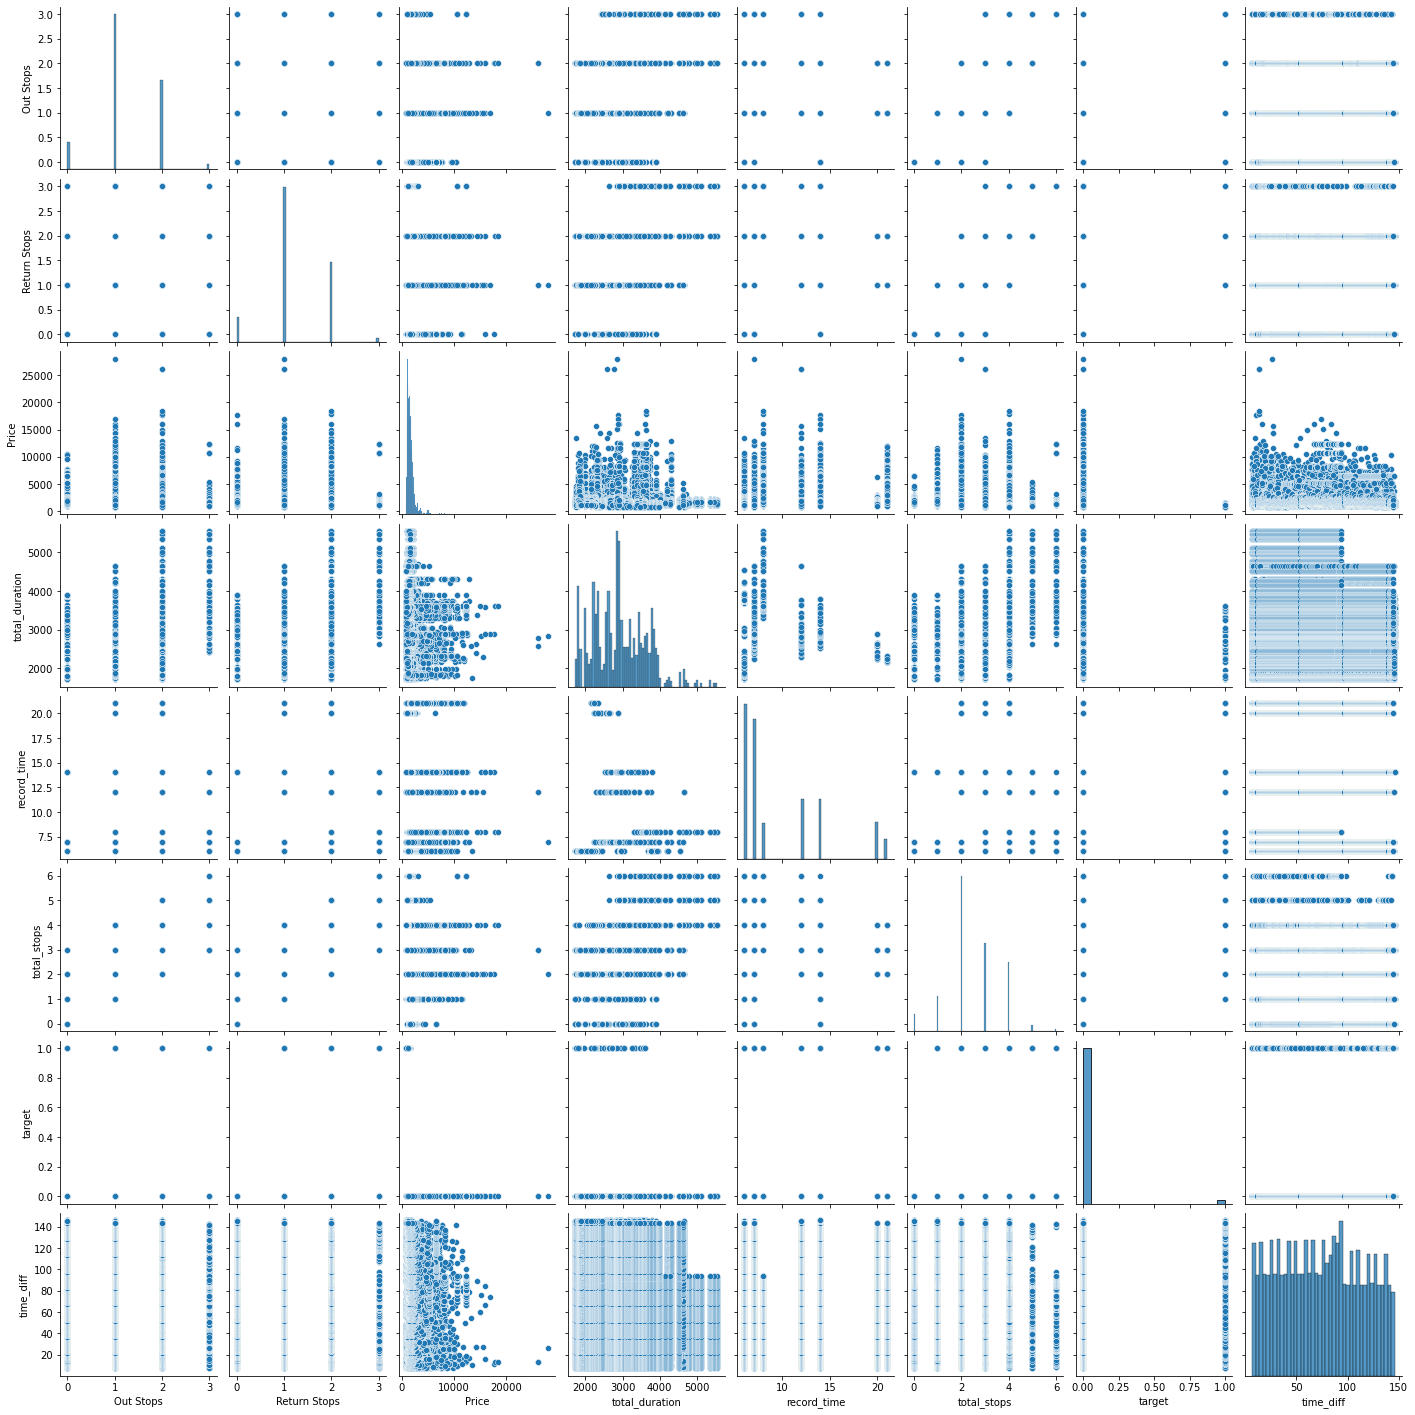

In [23]:
sns.pairplot(df);

<ul>
    <li>We can see that most of the data is relatively equally distributed</li>
    <li>Price is skewed to the right, but that is to be expected because there are outlier plane tickets present like business/first class tickets</li>
</ul>

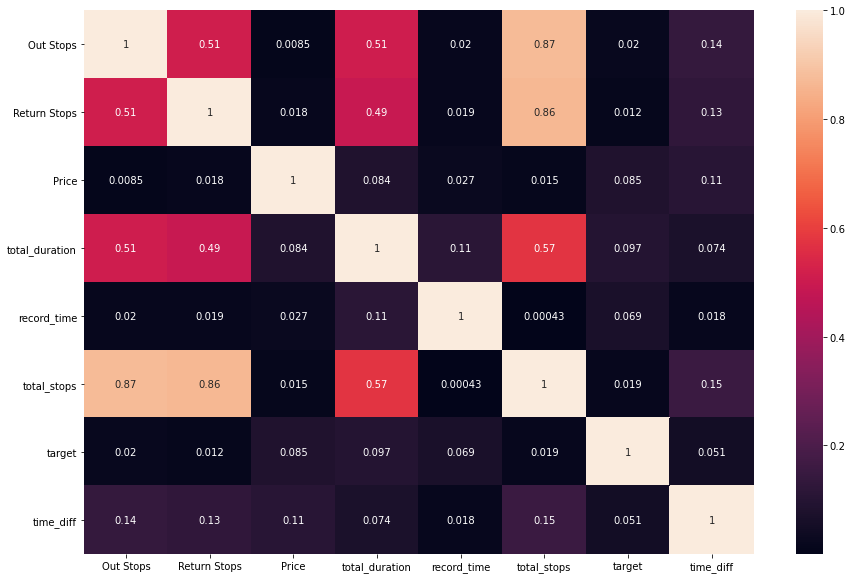

In [24]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.corr().abs(), annot = True);

<ul>
    <li>We see that there is not a lot of multicollinearity present in our data.</li>
    <li>The only variables with high multicollinearity are <code>Total stops</code> , <code>Return Stops</code> , and <code>Out Stops</code></li>
    <li>This is expected simply because we know that they are all directly related to each other.</li>
    <li><code>Total Duration</code> and <code>total_stops</code> also have some collinearity with each other, but it is not at the threshhold of <b>0.70</b> where it could be a cut off.</li>
</ul>

In [25]:
time_df = df.set_index(pd.to_datetime(df['departure_date']), drop=True)
ts_price = time_df['Price']

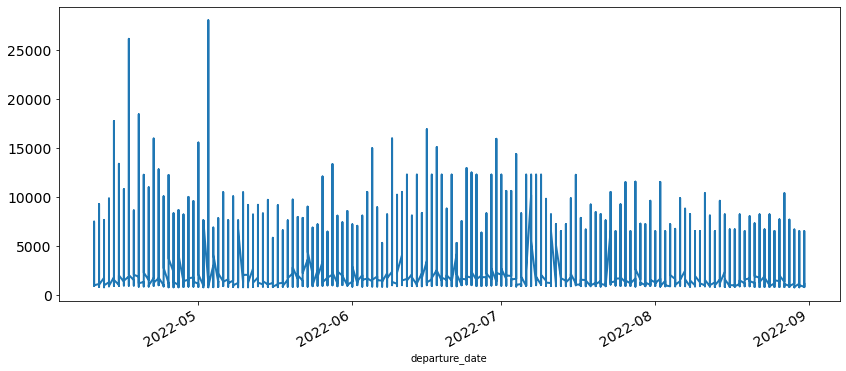

In [26]:
ts_price.plot(figsize=(14,6), linewidth=2, fontsize=14);

<ul>
    <li>We see that our price across time seems stationary.</li>
    <li>In order to confirm this we need to test for stationarity</li>
    <li>In this case I chose to use adfuller</li>
</ul>

In [27]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller(ts):
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(
                    dftest[0:4], 
                    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    alpha = 0.05
    is_stationary = dftest[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(dftest[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(dftest[1],3)}')
        
    display(dfoutput)

In [28]:
dicky_fuller(ts_price)

The data is stationary with a fuller score of 0.0


Test Statistic                -1.324724e+01
p-value                        8.922841e-25
#Lags Used                     5.900000e+01
Number of Observations Used    5.624300e+04
Critical Value (1%)           -3.430466e+00
Critical Value (5%)           -2.861591e+00
Critical Value (10%)          -2.566797e+00
dtype: float64

Here we can see that our data is indeed stationary


# Saving the compiled dataframe as <code>masterdf.csv</code>

---

In [29]:
df.to_csv('data/masterdf.csv', index=False) 

In [30]:
# Inspecting to ensure that it was correctly saved
df = pd.read_csv('data/masterdf.csv')
df.head()

,Out Time,Out Airline,Out Cities,Out Duration,Out Stops,Out Stop Cities,Return Time,Return Airline,Return Cities,Return Duration,...,dep_time,ret_time,record_time,dep_airline,ret_airline,departure_day,search_day,total_stops,target,time_diff
0,8:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,27h40m,2,"ATL, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,8:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0,7
1,9:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,26h40m,2,"BOS, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,9:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0,7
2,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,11:25,6:10,14,ANA,ANA,Sunday,Sunday,2,1,7
3,6:30 am – 12:35 am +2,ANA,EWR‐SIN,30h05m,2,"LAX, NRT",6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,6:30,6:10,14,ANA,ANA,Sunday,Sunday,3,0,7
4,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,10:10 pm – 9:27 pm +1,ANA,SIN‐EWR,35h17m,...,11:25,10:10,14,ANA,ANA,Sunday,Sunday,3,0,7
